**Needed Libraries**

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.datasets import mnist
from keras import backend as K
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from skimage.transform import resize

**Loading Dataset**

In [14]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

**Preprocessing**

In [15]:
# shuffling out data
train_data = list(zip(x_train, y_train))
shuffled_data = shuffle(train_data)

# Unziping the shuffled data
x_train, y_train = zip(*shuffled_data)

# Converting to NumPy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

print("Dimension of x_train is:", x_train.shape)
print("Dimension of y_train is:", y_train.shape)
print("Dimension of x_test is:", x_test.shape)
print("Dimension of y_test is:", y_test.shape)

Dimension of x_train is: (60000, 28, 28)
Dimension of y_train is: (60000,)
Dimension of x_test is: (10000, 28, 28)
Dimension of y_test is: (10000,)


**Ploting some of training data**

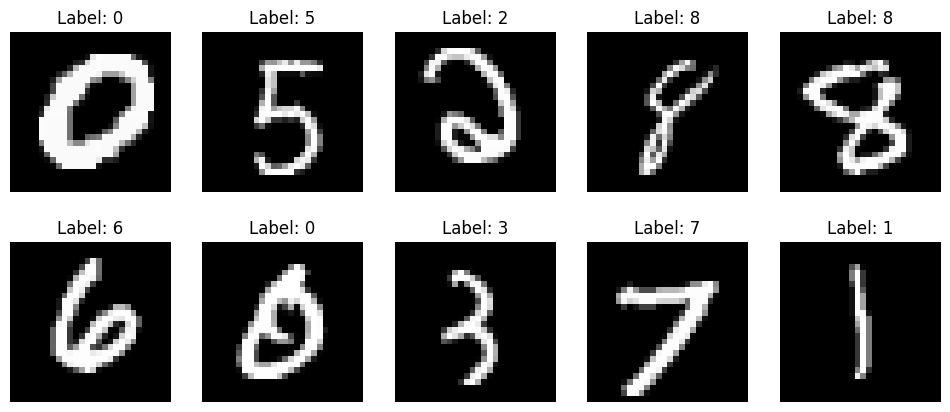

In [16]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

plt.show()

**Normalizing and Categoricalization**

In [17]:
x_train = x_train / 255.0
x_test = x_test / 255.0

num_classes = 10  # we have 10 classes
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

**Implementing the model**

In [18]:
model = Sequential()

# layer 1
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# layer 2
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# layer 3
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='last_conv_layer'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# FC layer 1
model.add(Dense(128, activation='relu'))

# Output layer
model.add(Dense(10, activation='softmax'))

**Compiling**

In [19]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

**Training and Testing**

In [20]:
history = model.fit(x_train, y_train, epochs=15, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/15
938/938 [==============================] - 147s 154ms/step - loss: 0.1597 - accuracy: 0.9503 - val_loss: 0.0640 - val_accuracy: 0.9789
Epoch 2/15
938/938 [==============================] - 88s 94ms/step - loss: 0.0452 - accuracy: 0.9860 - val_loss: 0.0357 - val_accuracy: 0.9887
Epoch 3/15
938/938 [==============================] - 87s 92ms/step - loss: 0.0320 - accuracy: 0.9898 - val_loss: 0.0450 - val_accuracy: 0.9863
Epoch 4/15
938/938 [==============================] - 88s 94ms/step - loss: 0.0254 - accuracy: 0.9920 - val_loss: 0.0308 - val_accuracy: 0.9901
Epoch 5/15
938/938 [==============================] - 88s 94ms/step - loss: 0.0202 - accuracy: 0.9933 - val_loss: 0.0254 - val_accuracy: 0.9916
Epoch 6/15
938/938 [==============================] - 88s 94ms/step - loss: 0.0170 - accuracy: 0.9944 - val_loss: 0.0236 - val_accuracy: 0.9917
Epoch 7/15
938/938 [==============================] - 92s 98ms/step - loss: 0.0146 - accuracy: 0.9953 - val_loss: 0.0266 - val_accurac

**Grad-Cam**

In [21]:
def grad_cam(img):
  last_conv_layer = model.get_layer('last_conv_layer')
  heatmap_model = tf.keras.models.Model(inputs=model.inputs, outputs=[last_conv_layer.output, model.output])


  with tf.GradientTape() as tape:
      conv_outputs, predictions = heatmap_model(x_test[:10].reshape(-1, 28, 28, 1))
      loss = predictions[:, tf.argmax(predictions[0])]
      grads = tape.gradient(loss, conv_outputs)
      gradients_pool = K.mean(grads, axis = (0, 1, 2))
  heatmap = tf.reduce_mean(tf.multiply(gradients_pool, conv_outputs), axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

**Illustrating the result**

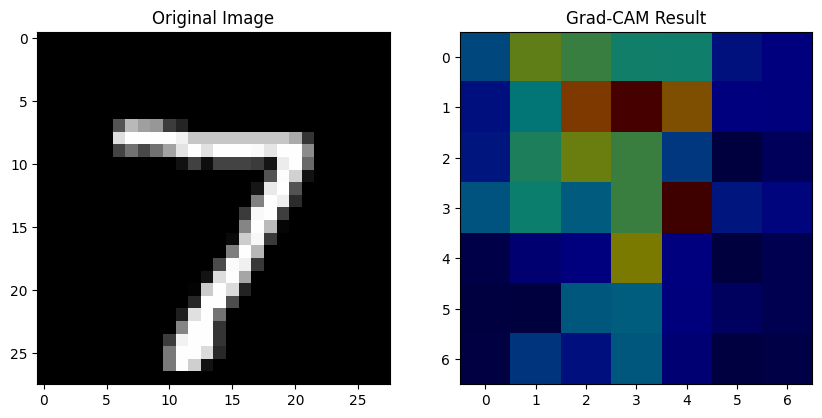

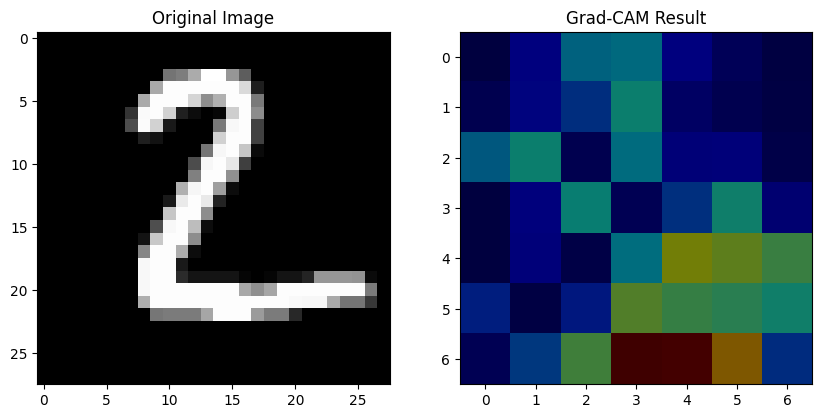

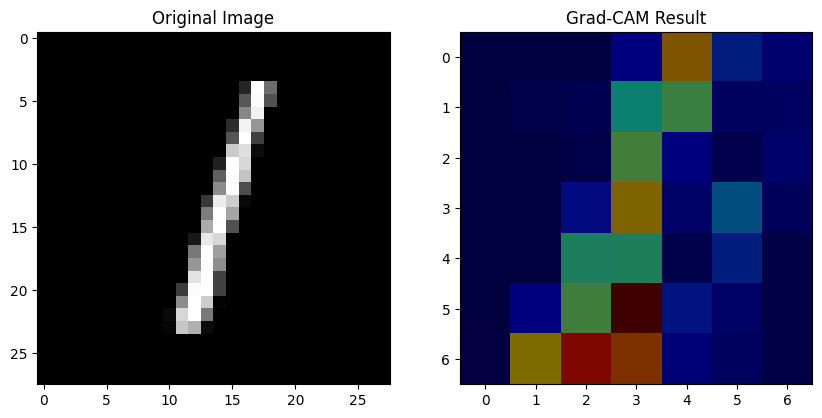

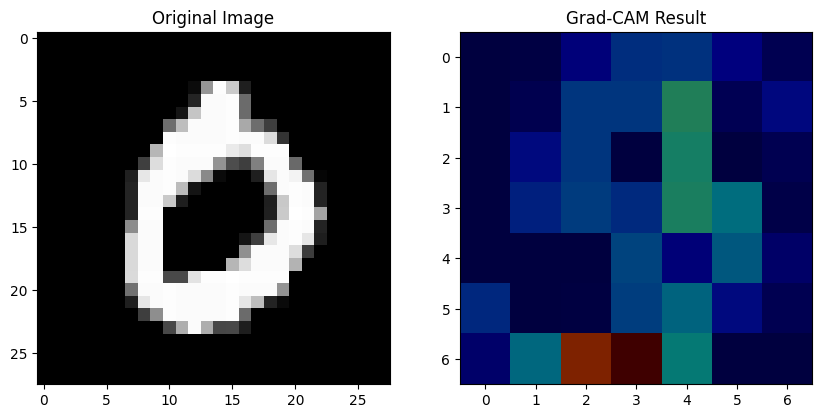

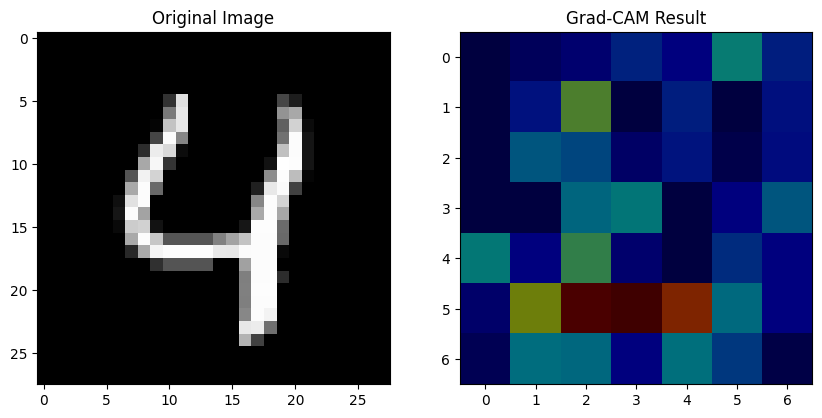

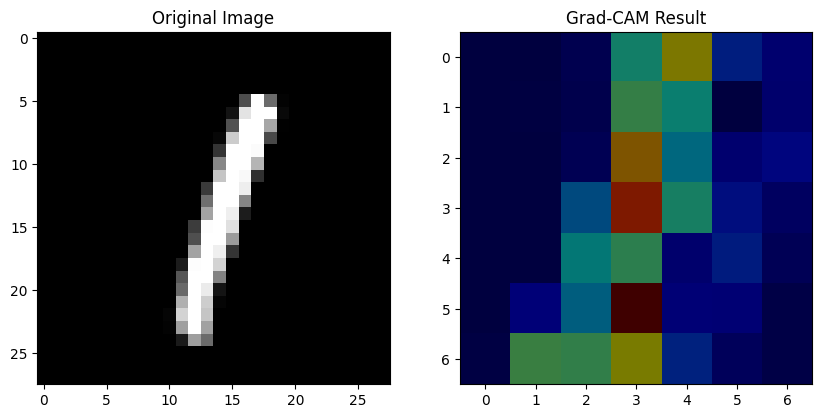

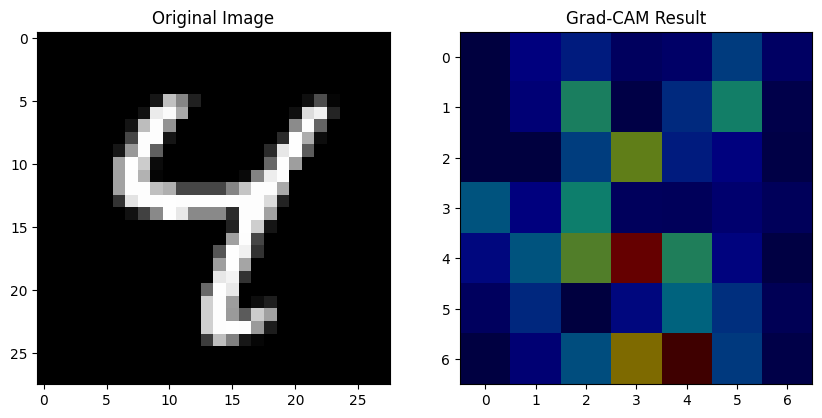

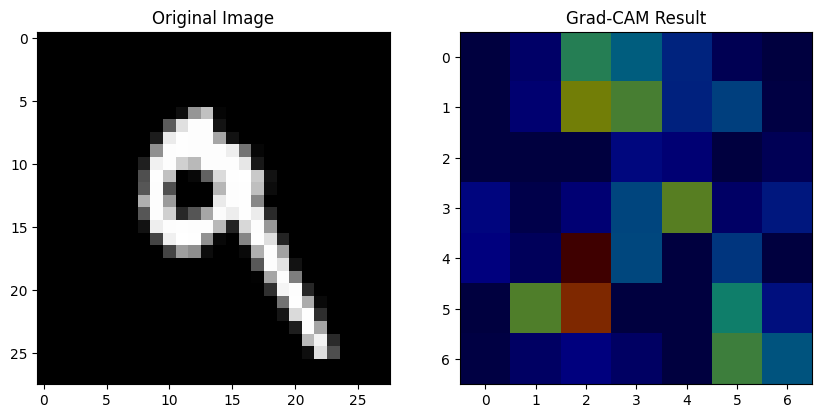

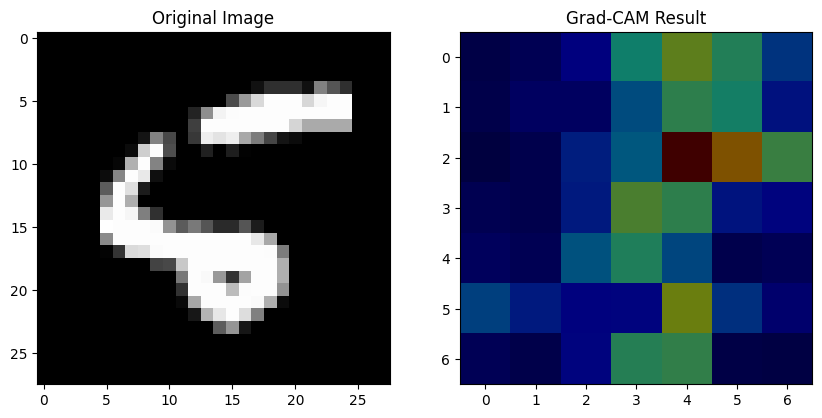

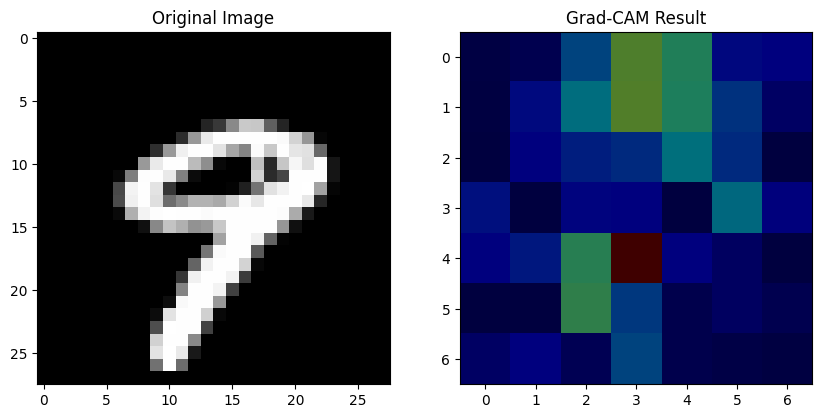

In [22]:
for i in range(10): # for 10 images
    img = x_test[i]
    plt.figure(figsize=(10, 5))

    # Original
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title('Original Image')

    # Grad-CAM
    plt.subplot(1, 2, 2)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.imshow(grad_cam(img)[i], cmap='jet', alpha=0.5)
    plt.title('Grad-CAM Result')

    plt.show()